In [1]:
from pathlib import Path
from datetime import datetime
import sys
import yaml
from time import time
import os
import copy
from geopy.geocoders import GoogleV3, Nominatim
import matplotlib.dates as mdates
from numpy import median

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import lines

DIR = Path('..')
sys.path.insert(0, str(DIR))
from SCanalyzer import SCanalyzer
from SCanalyzer.busSim import BusSim, Config
from SCanalyzer.busSim.manager import managerFactory
from SCanalyzer.gtfs_edit import edit_double
from SCanalyzer.util import findEPSG
from SCanalyzer.busSim.manager import LocalManager
from pyproj import Transformer

import matplotlib.pyplot as plt
from matplotlib import lines

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

from shapely import geometry

%matplotlib inline

manger init
mangager register
mangager register


In [19]:
def flatten(s):
    return gpd.GeoDataFrame({"geometry": gpd.GeoSeries([s.unary_union]), 'crs': 32616})

def gen_busSim(data_path=None, out_path=None, day=None, start_time=None, elapse_time=None, avg_walking_speed=None, max_walking_min=None):
    manager = LocalManager(data_path, out_path, None)
    busSim = BusSim(manager, day, start_time, elapse_time, avg_walking_speed, max_walking_min)
    return busSim

def get_area(start_points=[], start_locations=[], busSim=None, crs=32616, city=None):
    if len(start_points)==0:
        geolocator = Nominatim(user_agent="user_test")
        for loc in start_locations:
            location = geolocator.geocode(loc)
            print(location)
            start_point = (location.latitude, location.longitude)
            start_points.append(start_point)
    
    area_dict = {}
    # print(f'{start_points=}')
    for index, start in enumerate(start_points):
        print(f'{start=}')
        gdf = busSim.get_gdf(start_point=start)
        busSim.clear_graph()
        if gdf is None:
            area_dict[f'{start_points[index]}'] = 0
            continue
        gdf = gdf.to_crs(epsg=32616)
        bubble = flatten(gdf.geometry)
        new_census2 = census_gdf.to_crs(crs).intersection(bubble.unary_union)
        new_census2 = gpd.GeoDataFrame(geometry=new_census2, crs=crs)
        new_census2['score'] = new_census['score']
        area_dict[f'{start_points[index]}'] = new_census2[~new_census2['geometry'].is_empty]['score'].sum()
    print(f'{area_dict=}')
    return area_dict

def draw_area_times(times, areas, data_path, results):
    fig, ax = plt.subplots(figsize=(12,8)) 
    times = list(map(lambda x: datetime.strptime(x.capitalize(), "%A %H:%M:%S  %d"), times))
    formatter = mdates.DateFormatter("%a %H:%M")
    plt.gca().xaxis.set_major_formatter(formatter)
    plt.gcf().autofmt_xdate()
    
    for key in areas.keys():
        print(f'loc {key}')
        print(f'{areas[key]=}')
        print(f'min value: {min(areas[key])}')
        results['min coverage'].append(min(areas[key]))
        results['max coverage'].append(max(areas[key]))
        results['median coverage'].append(median(areas[key]))
        print(f'max value: {max(areas[key])}')
        geoloctor = Nominatim(user_agent="reverse_user")
        info = geoloctor.reverse(key[1:-1]).raw
        if info != None:
            info = info['address']
            addr = ''
            for index, addrkey in enumerate(info):
                if index > 1:
                    break
                addr += " " + info[addrkey]
        else:
            addr = key
        ax.plot(times, areas[key], label = addr)
        results['label'].append(addr)
    
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlabel('Time', fontsize=18)
    plt.ylabel("Area coverage "+ r'$(km^2)$', fontsize=18)
    plt.title('Area Coverage vs Time')
    plt.legend()
    plt.savefig('mearsurement_plot.png')

def run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results):
    prog_start = time()
    areas = {}
    for start_time in start_times:
        # print('creat busSim')
        day, start = start_time.split(' ')
        busSim = gen_busSim(DATA_PATH,OUT_PATH, day, start, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN)
        # print('cal area')
        for key, area in get_area(start_points=START_POINTS, start_locations=START_LOCATIONS, busSim=busSim, crs=crs).items():
            if key not in areas:
                areas[key] = []
                areas[key].append(float(area))
            else:
                areas[key].append(float(area))
    # print(f'{areas=}')
    pre_day = ''
    day_index = 0
    for index in range(len(start_times)):
        day, start = start_times[index].split(' ')
        if pre_day != day:
            day_index+=1
            pre_day = day
        start_times[index] = f"{start_times[index]}  {day_index}"
        
    print(start_times)
    draw_area_times(start_times, areas, DATA_PATH, results)
    duration = time() - prog_start
    # results['time'].append(duration)
    print(f'time taken {duration}')
    return duration

In [3]:
def get_score(area, banks=0, clinics=0, dentists=0, hospitals=0, supermarkets=0):
    x6 = 1
    if banks == 0:
        x6 = x6/2
    if supermarkets == 0:
        x6 = x6/2
    if hospitals == 0:
        x6 = x6/2
    if clinics == 0:
        x6 = x6/2
    if dentists == 0:
        x6 = x6/2
    score = (area + banks + clinics + hospitals + dentists + supermarkets) * x6
    return score

In [4]:
api_key = 'ZsHZFGtKEZeOOXhTne98eErmfd6BfNTm9GqO2S6inSnWzDwtgC2sEauXcB-8zUna_lXZEal4jsW_St6O0OQOcuNvifrr6uqNYmjFXW-FyVKvaMyczbihWELI80tjYHYx'
gtfo = SCanalyzer(os.path.join('..', 'data', 'lansing_gtfs.zip'))
census_gdf = gtfo.load_census()
services_gdf = gtfo.load_yelp(api_key=api_key)

stops_meter exists


In [5]:
# the number of each building in each census block
new_census = census_gdf.copy(True)
new_census['banks'] = 0
new_census['clinics'] = 0
new_census['dentists'] = 0
new_census['hospitals'] = 0
new_census['supermarket'] = 0
for idx, row in new_census.bounds.iterrows():
    for _, service in services_gdf.iterrows():
        if row['miny'] <= service['latitude'] <= row['maxy'] and row['minx'] <= service['longitude'] <= row['maxx']:
            new_census.loc[idx, service['service']] += 1

In [6]:
new_census['score'] = new_census.apply(axis=1, func=lambda row: get_score(0, row['banks'], row['clinics'], row['dentists'], row['hospitals'], row['supermarket']))

len(start_points_dict["high"])=10
stops_meter exists
start=(42.70154967243691, -84.5492375391658)
start=(42.70154967243691, -84.5492375391658)
start=(42.7089628139353, -84.54494465393294)
start=(42.700336171040526, -84.54284497805143)
start=(42.71004236075822, -84.40608454957669)
start=(42.689978589189316, -84.54221142906732)
start=(42.7650948183785, -84.49947250001442)
start=(42.72571904933564, -84.45452833285272)
start=(42.73088680199716, -84.47358345971233)
start=(42.729934705198126, -84.46865888239998)
area_dict={'(42.70154967243691, -84.5492375391658)': 41.3125, '(42.7089628139353, -84.54494465393294)': 45.5, '(42.700336171040526, -84.54284497805143)': 51.9375, '(42.71004236075822, -84.40608454957669)': 36.125, '(42.689978589189316, -84.54221142906732)': 52.625, '(42.7650948183785, -84.49947250001442)': 47.875, '(42.72571904933564, -84.45452833285272)': 70.25, '(42.73088680199716, -84.47358345971233)': 84.0625, '(42.729934705198126, -84.46865888239998)': 84.0625}
start=(42.7015496

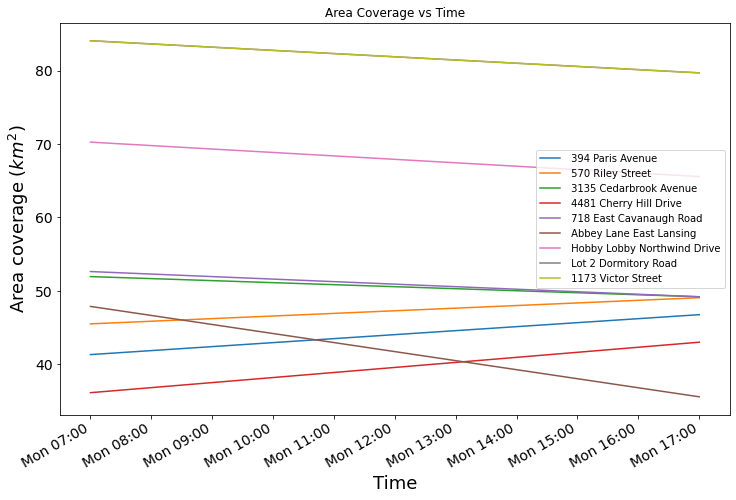

In [20]:
start_points_dict = {'low': [(42.69552749899424, -84.59724385814187), (42.678903862848266, -84.59248159369493), (42.70093874047502, -84.5972371795897), (42.7007910840444, -84.5572856246274), (42.677790726888496, -84.57890510682235), (42.69182814771287, -84.61354679022507), (42.68622809427853, -84.56495335422156), (42.67809941765349, -84.5682437067551), (42.71365682127145, -84.53426523200933), (42.70780457246975, -84.56169111850734)], 'high': [(42.70154967243691, -84.5492375391658), (42.70154967243691, -84.5492375391658), (42.7089628139353, -84.54494465393294), (42.700336171040526, -84.54284497805143), (42.71004236075822, -84.40608454957669), (42.689978589189316, -84.54221142906732), (42.7650948183785, -84.49947250001442), (42.72571904933564, -84.45452833285272), (42.73088680199716, -84.47358345971233), (42.729934705198126, -84.46865888239998)]}

results = {
    "label":[],
    "max coverage": [],
    "min coverage": [],
    "median coverage": []
}

print(f'{len(start_points_dict["high"])=}')
START_POINTS = start_points_dict['high']
ELAPSE_TIME = "00:30:00"
AVG_WALKING_SPEED = 1.4 # 1.4 meters per second
MAX_WALKING_MIN = 12

DATA_PATH = "../data/lansing_gtfs.zip"
OUT_PATH = "/tmp/output" 
sc = SCanalyzer(DATA_PATH)
crs = sc.epsg
START_LOCATIONS = []

runs = []
start_times = []
days = ["monday", "tuesday", "wednesday", "thursday", "friday", "saturday", "sunday"]
days = ["monday"]
for day in days:
    for start_time in range(7,22,10):
        start_times.append('{} {:02}:{:02}:{:02}'.format(day, start_time, 0, 0))    
runs.append(run(start_times, DATA_PATH, OUT_PATH, ELAPSE_TIME, AVG_WALKING_SPEED, MAX_WALKING_MIN, START_POINTS, START_LOCATIONS, crs, results))